# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize
from constants import *

In [3]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 5e-3
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 20
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [4]:
HOC_NUM = 3
DATA_SZ = -1
# train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts =\
# utils.load_dataset_predict_ast(hoc_num=HOC_NUM, data_sz=DATA_SZ)

X, y, ast_maps, embed_dim = utils.load_dataset_predict_ast_using_embeddings(hoc_num=HOC_NUM, data_sz=DATA_SZ)

Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (4436, 7, 218)
218
3899
Inputs and targets done!


In [5]:
num_traj, num_timesteps, embed_dim = X.shape

X_train = X[0:7*num_traj/8]
X_val =  X[7*num_traj/8: 15*num_traj/16 ]
X_test = X[15*num_traj/16:num_traj]

y_train = y[0:7*num_traj/8]
y_val =  y[7*num_traj/8: 15*num_traj/16]
y_test = y[15*num_traj/16:num_traj]

train_data = X_train, y_train
val_data = X_val, y_val
test_data = X_test, y_test
print X_train.shape
print y_train.shape
print X_val.shape
print X_test.shape

(3881, 6, 256)
(3881, 6)
(277, 6, 256)
(278, 6, 256)


In [6]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, hidden_size, learning_rate, embed_dim, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


/Users/lisa1010/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [7]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 2420
Ep 0 	iter 1  	loss 5.55854, train acc 0.00, train corr acc 0.00, val acc 57.04, val corr acc 28.46
Ep 0 	iter 2  	loss 5.32156, train acc 56.25, train corr acc 26.32, val acc 56.62, val corr acc 27.76
Ep 0 	iter 3  	loss 4.73541, train acc 59.38, train corr acc 29.73, val acc 57.10, val corr acc 28.56
Ep 0 	iter 4  	loss 3.74705, train acc 57.29, train corr acc 28.70, val acc 56.98, val corr acc 28.36
Ep 0 	iter 5  	loss 2.73697, train acc 53.12, train corr acc 26.83, val acc 56.98, val corr acc 28.36
Ep 0 	iter 6  	loss 2.07276, train acc 52.60, train corr acc 25.41, val acc 56.62, val corr acc 27.76
Ep 0 	iter 7  	loss 1.68127, train acc 58.33, train corr acc 28.57, val acc 56.62, val corr acc 27.76
Ep 0 	iter 8  	loss 1.81845, train acc 55.21, train corr acc 27.12, val acc 56.62, val corr acc 27.76
Ep 0 	iter 9  	loss 1.82321, train acc 57.29, train corr acc 28.07, val acc 56.62, val corr acc 27.76
Ep 0 	iter 10  	loss 1.94080, t

In [8]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')

Testing...
Final results:
  test loss:			1.099203
  test raw accuracy:		70.68 %
  test corrected accuracy:	51.39 %


In [11]:
# Convert to AST IDs so we can look at the AST json files
traj_row_to_ast_id_map = ast_maps['traj_row_to_id']
X_test, y_test = test_data
y_test_ast_ids = utils.convert_truth_to_ast_ids(y_test, traj_row_to_ast_id_map)
pred_test_ast_ids = utils.convert_pred_to_ast_ids(pred_test, traj_row_to_ast_id_map)

print ("Truth AST IDs")
print y_test_ast_ids[10:30, :]
print("Predicted AST IDs")
print pred_test_ast_ids[:60,:]

Truth AST IDs
[[ 13.   6.   0.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.]
 [ 45.   0.  -1.  -1.  -1.  -1.]
 [ 10.   0.  -1.  -1.  -1.  -1.]
 [ 15.  -1.  -1.  -1.  -1.  -1.]
 [ 11.   5.   0.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.]
 [  1.   8.   2.   0.  -1.  -1.]
 [  2.  25.  13.   0.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.]
 [  6.   0.  -1.  -1.  -1.  -1.]
 [ 44.  14.  -1.  -1.  -1.  -1.]
 [ 17.   0.  -1.  -1.  -1.  -1.]
 [ 22.   0.  -1.  -1.  -1.  -1.]
 [  2.   7.   0.  -1.  -1.  -1.]
 [ 21.   0.  -1.  -1.  -1.  -1.]
 [  2.   1.   0.  -1.  -1.  -1.]
 [  7.   1.   8.   0.  -1.  -1.]
 [ 10.  13.   2.   1.   0.  -1.]
 [  1.  19.   0.  -1.  -1.  -1.]]
Predicted AST IDs
[[  1.   0.   1.  -1.  -1.  -1.]
 [  8.   0.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.]
 [  1.  -1.   0.   0.  -1.  -1.]
 [  2.   0.   1.   0.   0.  -1.]
 [  1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.   0.  -1.  -1.  -1.]
 [ 10.  -1.   0.   0.  -1.  -1.]
 [  1.   1

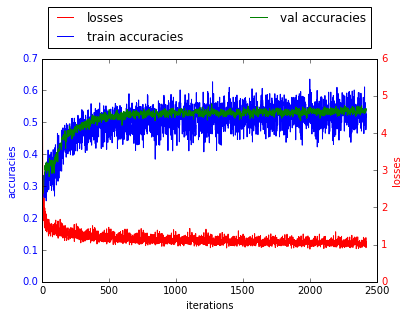

In [10]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = train_data[0].shape[0]
visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')